In [1]:
from cosmopystats.cosmomodels import CosmoModel
from cosmopystats.stats.mcmc import MCMC
from cosmopystats.utils import Timing, setup_text_plots, progressbar
from cosmopystats.data.dataLoaders import get_unionSN21Data, get_unionSN21Covmat
from cosmopystats.utils.dataPlotters import plotHubbleDiagram, plotmu
import matplotlib.pyplot as plt
import numpy as np
import emcee
import os
%matplotlib inline

In [2]:
#  weight: 'normal',  'light', 'bold'
setup_text_plots(fontsize=20, family='serif', style='normal', weight='bold', usetex=True)

In [3]:
def lnp(theta, mcmc):
    """docstring for lnp"""
    return mcmc.lnp(theta)

------------------------------
Number of SuperNova Loaded :580
------------------------------
------------------------------
Covariance Matrix is a (580,580) matrix
------------------------------
Getting best initial guess for walkers (scipy minimization)...


[==================================================>] 100 % DONE!

******************************
Plotting MCMC chains...
******************************


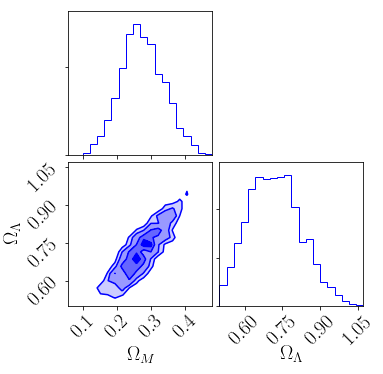


Mean acceptance fraction: 0.708833333333 


In [5]:
BE_VERBOSE = False
N_WALKERS = 6  # 6, 50
CHAINS_STEPS = 1000  # 50, 1000
BURN = 100  #2,  100
COLOR_DENSE_2D = 'b'
# USE_MPI = False
SAVE_CHAINS = False
PRINT_STEP = 1  # print advance every (PRINT_STEP) %
# ---------------------------------------------
# ---------------------------------------------
# DATA
# ---------------------------------------------
SN21_data = get_unionSN21Data()
SN21_covmat = get_unionSN21Covmat()
# ---------------------------------------------
model = CosmoModel(pars={"OmegaM": [0.3, 0.2, 0.5, True],
                         "OmegaR": [0.00005, 0.0, 0.0, False],
                         "OmegaL": [0.6, 0.5, 1.0, True],
                         "H0": [63.0, 60.0, 80.0, True]})
# ---------------------------------------------
mcmc = MCMC(model=model, data=SN21_data, covmat=SN21_covmat,
            version='emcee', nWalkers=N_WALKERS,
            chainSteps=CHAINS_STEPS, burnin=BURN,
            color=COLOR_DENSE_2D, MPI=False, verbose=BE_VERBOSE)
# ---------------------------------------------

# mcmc.Run_and_Plot()
# chains = mcmc.getMCMC()
pos0 = mcmc.getGuessForWalkers()
sampler = emcee.EnsembleSampler(mcmc.nWalkers, mcmc.Ndims, mcmc.lnp)

# Run 100 steps as a burn-in.
pos1, prob, state = sampler.run_mcmc(pos0, BURN)

# Reset the chain to remove the burn-in samples.
sampler.reset()

# sampler.run_mcmc(pos1, mcmc.chainSteps, rstate0=state)
print "\n"
for i, result in enumerate(sampler.sample(pos1, iterations=mcmc.chainSteps,
                                          storechain=True, rstate0=state)):
    if SAVE_CHAINS is True:
        position = result[0]
        f = open("chains/chain_single.dat", "a")
        for k in range(position.shape[0]):
            f.write("{0:4d} {1:s}\n".format(k, " ".join(str(position[k]))))
        f.close()
    if (i+1) % PRINT_STEP == 0:
        progressbar(advance=i+1, total=mcmc.chainSteps)

mcmc.plotMCMC(sampler, save_plots=True)
plt.show()
mcmc.report(sampler)